In [1]:
# for loading/processing the images  
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors

# models 
from keras.applications.vgg16 import VGG16 
from keras.models import Model

# for data visualization and plotting
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.manifold import TSNE

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn_extra.cluster import KMedoids
from sklearn.decomposition import PCA
import hdbscan
from sklearn.cluster import AgglomerativeClustering

# Metrics
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# for everything else
import os
import shutil
import numpy as np
from random import randint
import pandas as pd
import pickle
from PIL import Image
from progressbar import ProgressBar
from __future__ import print_function
import time

In [2]:
path = r"C:\Users\Dennis\Documents\SE512\Data_Mining_Project\Images_from_S3_3"

In [3]:
# change the working directory to the path where the images are located
os.chdir(path)

In [4]:
# this list holds all the image filename
drone_images = []

In [5]:
drone_images.clear()

In [6]:
# creates a ScandirIterator aliased as files
with os.scandir(path) as files:
  # loops through each file in the directory
    for file in files:
        if file.name.endswith('.png'):
          # adds only the image files to the flowers list
            drone_images.append(file.name)

In [7]:
# view the first x image entries
# print(drone_images[:1000])

In [8]:
model = VGG16()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

In [9]:
pbar = ProgressBar()

In [10]:
def extract_features(file, model):
    # load the image as a 224x224 array
    img = load_img(file, target_size=(224,224))
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img) 
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3) 
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)
    return features

In [11]:
data = {}
p = r"D:\features_final.pkl"

In [12]:
# loop through each image in the dataset
for drone_image in pbar(drone_images):
    # try to extract the features and update the dictionary
    try:
        feat = extract_features(drone_image,model)
        data[drone_image] = feat
    # if something fails, save the extracted features as a pickle file (optional)
    except:
        with open(p,'wb') as file:
            pickle.dump(data,file)

100% |########################################################################|


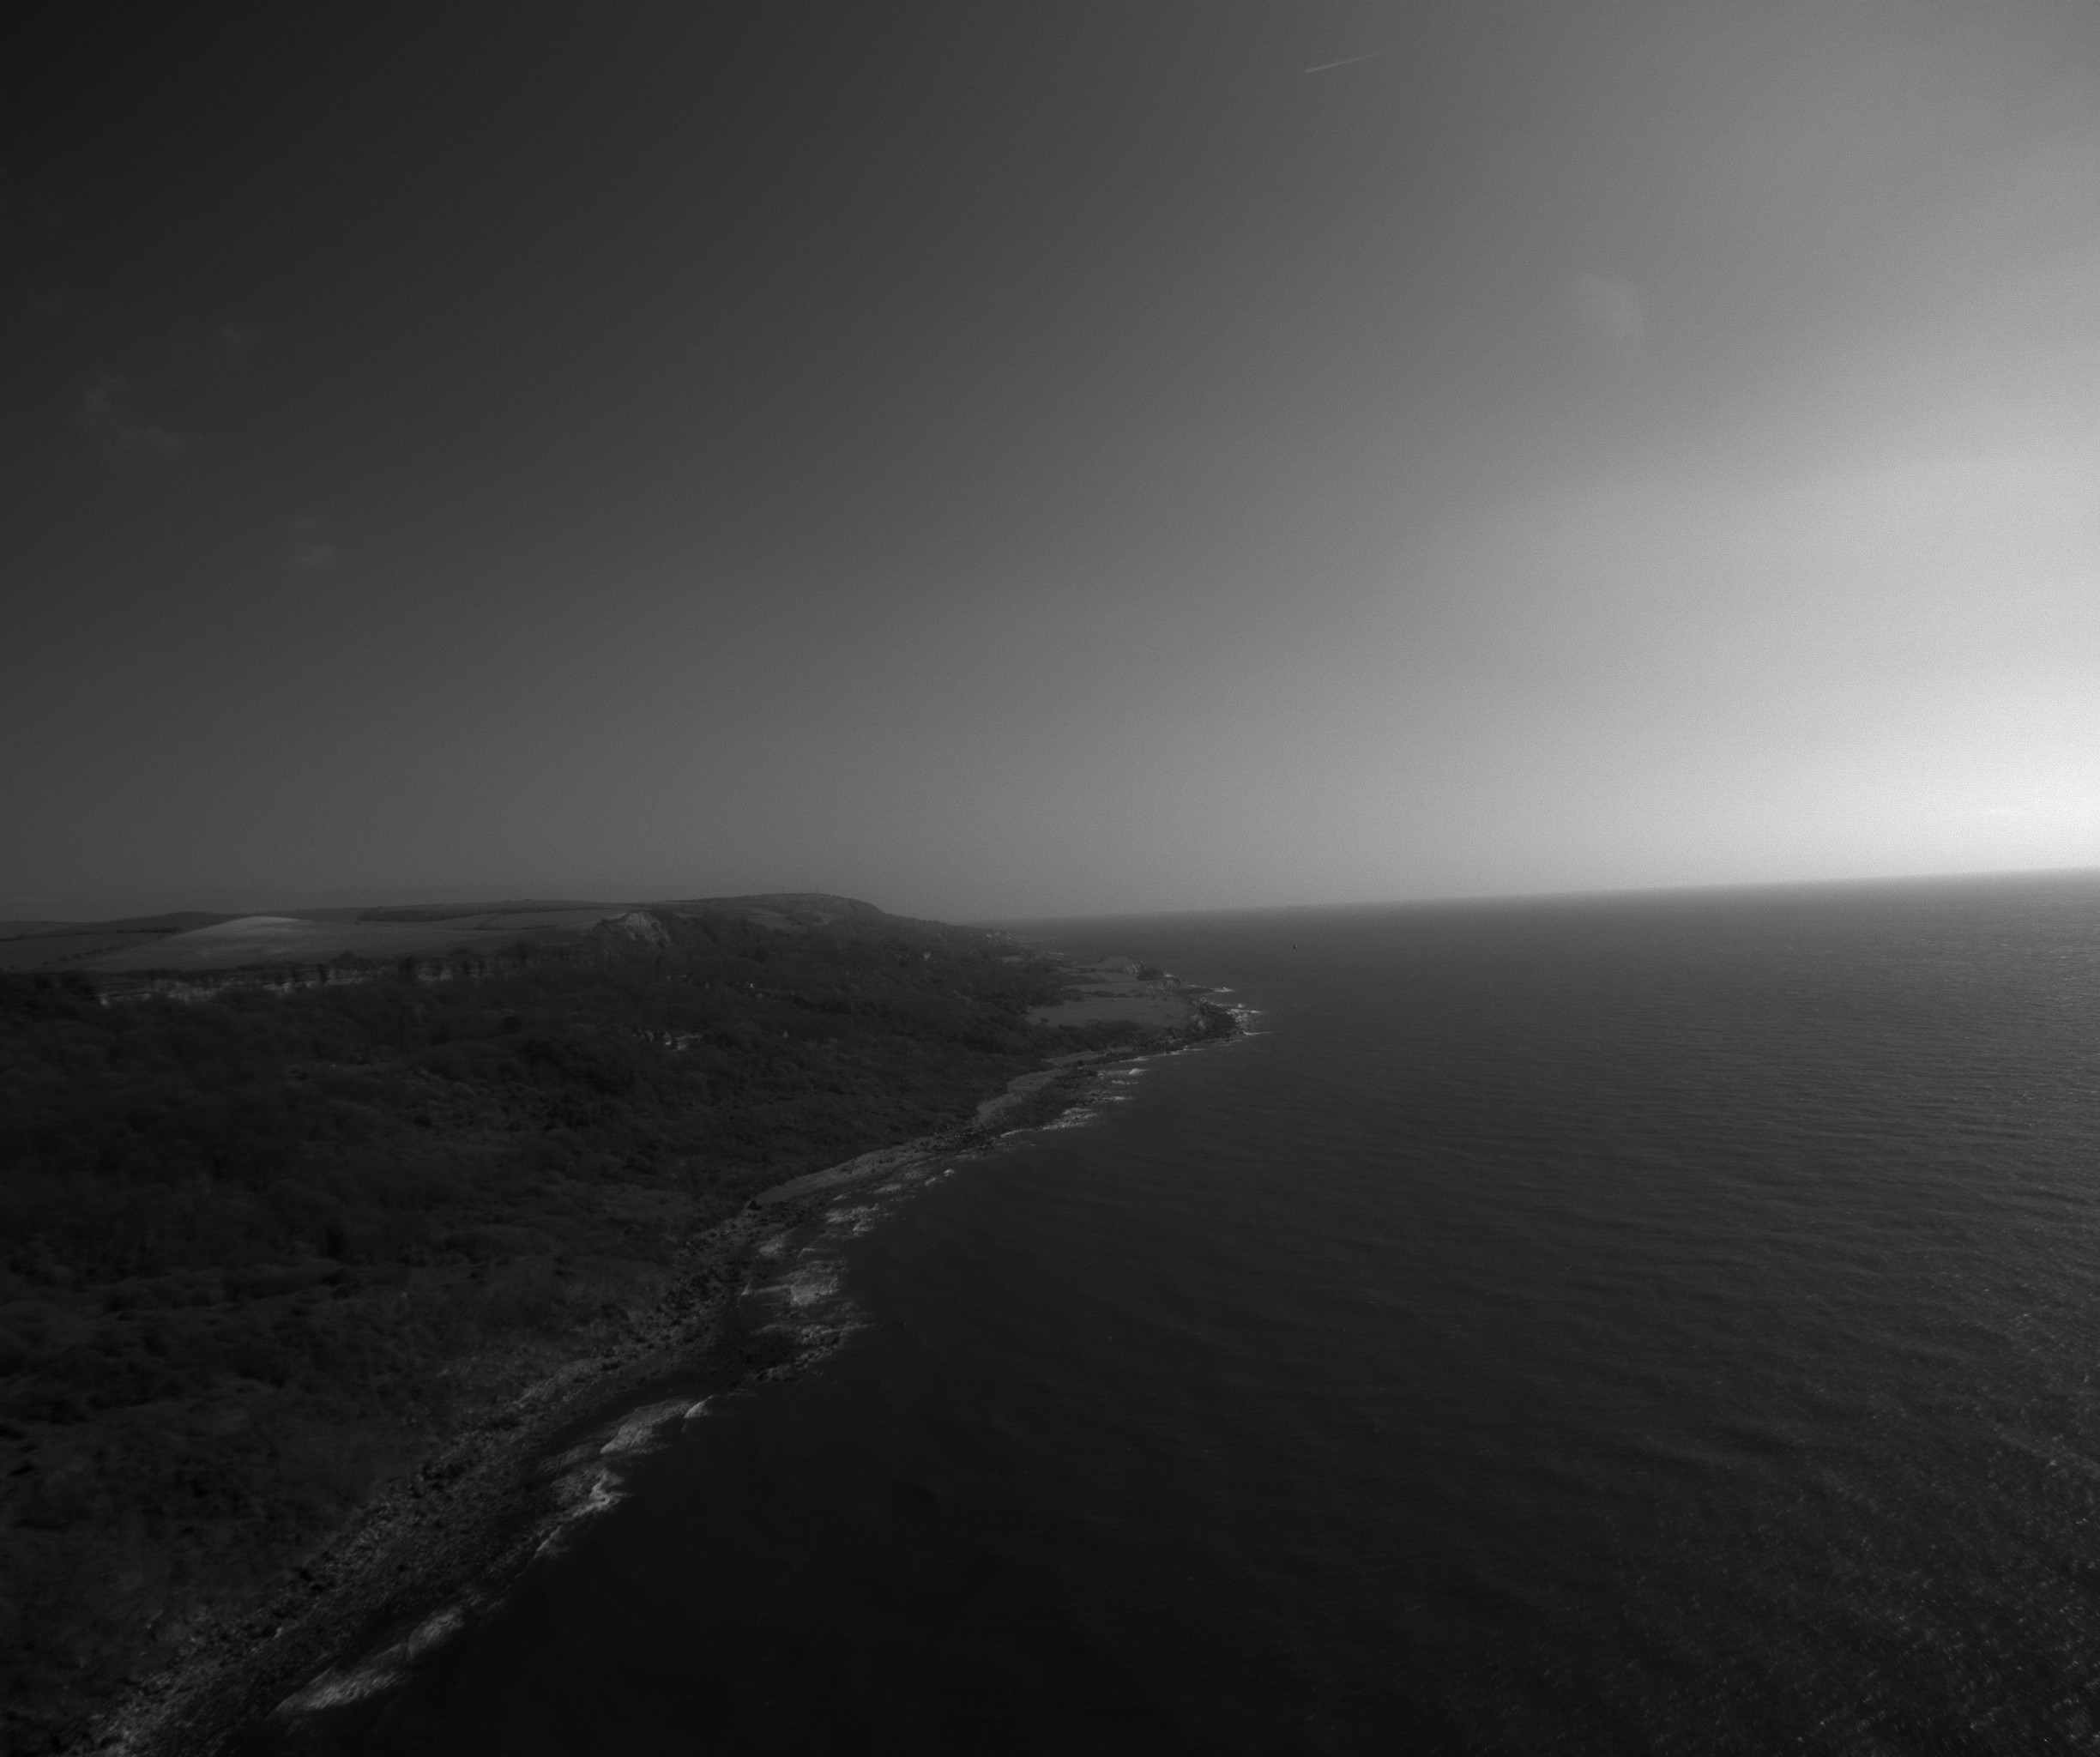

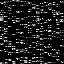

In [19]:
#read the image
vgg_array = np.array(feat[0])
vgg_array = np.reshape(vgg_array, (64, 64))
vgg_image = Image.fromarray(vgg_array, mode="L")
vgg_image.save('vgg_image.png')

im = Image.open('C:\\Users\\Dennis\\Documents\\SE512\\Data_Mining_Project\\Images_from_S3_3\\0.png')
im2 = Image.open('C:\\Users\\Dennis\\Documents\\SE512\\Data_Mining_Project\\Images_from_S3_3\\vgg_image.png')

display(im)
display(im2)

In [26]:
# To save feature vector as a pickle file to use later
# with open('data2.pickle','wb') as file:
#    pickle.dump(data,file)

In [27]:
# Location where pickle file is
# os.path.abspath("data.pickle")

In [9]:
# to load pickle file into data
with open('data.pickle','rb') as file:
   data = pickle.load(file)

In [10]:
# get a list of the filenames
filenames = np.array(list(data.keys()))

In [11]:
# get a list of just the features
feat = np.array(list(data.values()))

In [12]:
feat.shape

(3926, 1, 4096)

In [13]:
# reshape so that there are 3926 samples of 4096 vectors
feat = feat.reshape(-1,4096)

In [14]:
feat.shape

(3926, 4096)

In [15]:
# reduce the amount of dimensions in the feature vector
pca = PCA(n_components=100, random_state=22)
pca.fit(feat)
x = pca.transform(feat)

In [16]:
print(f"Components before PCA: {feat.shape[1]}")
print(f"Components after PCA: {pca.n_components}")

Components before PCA: 4096
Components after PCA: 100


## Visualizing the Data

In [17]:
scaler = MinMaxScaler()
data_rescaled = scaler.fit_transform(feat)

In [18]:
pca = PCA()
pca.fit(data_rescaled)

PCA()

In [19]:
pca.explained_variance_ratio_

array([1.00243405e-01, 8.46569687e-02, 6.36529252e-02, ...,
       4.33948377e-10, 3.47168405e-10, 1.15015224e-14], dtype=float32)

Text(0, 0.5, 'Cumulative Explained Variance')

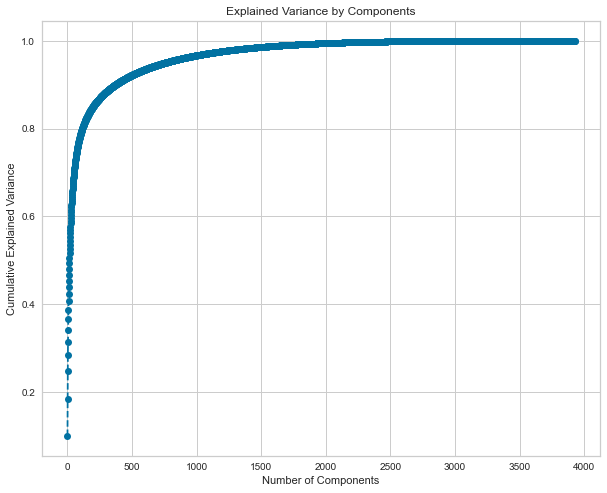

In [20]:
plt.figure(figsize = (10,8))
plt.plot(range(1,3927), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

In [21]:
feat_cols = [ 'pixel'+str(i) for i in range(x.shape[1]) ]

In [22]:
df = pd.DataFrame(x,columns=feat_cols)

In [23]:
print('Size of the dataframe: {}'.format(df.shape))

Size of the dataframe: (3926, 100)


In [24]:
print(df)

         pixel0     pixel1     pixel2    pixel3     pixel4    pixel5  \
0     18.050102   9.825347  -1.674040  9.194637  -3.724342 -0.314372   
1     20.795212   6.134831  -1.666899  6.431964   1.209288 -1.866498   
2      3.490874  -3.519213  24.917503  1.405557  17.807152  6.410273   
3    -18.779404   8.465126  -4.320560  0.363320   1.027052  3.116292   
4     -9.111311  22.781288   9.473549  7.102752   2.145095 -3.257959   
...         ...        ...        ...       ...        ...       ...   
3921  14.291780  11.265901  -5.830218  4.881590  -4.251918 -6.052071   
3922  15.969281  12.883835  -3.942784  3.072859  -2.519289 -7.919963   
3923  12.513400  14.768134  -6.020076  1.790191  -4.245585 -8.838089   
3924  -9.663340  32.794865   9.152996  2.053158  -0.366873  1.513896   
3925  -7.977242  30.035582   9.616441 -1.219236  -2.018043 -5.780442   

         pixel6    pixel7    pixel8    pixel9  ...   pixel90   pixel91  \
0    -11.042409  5.053004  8.272884  5.406934  ...  0.347492 

## Visualization after PCA

In [25]:
# reduce the amount of dimensions in the feature vector
pca = PCA(n_components=100, random_state=22)
pca.fit(feat)
x = pca.transform(feat)

In [26]:
pca = PCA(n_components=100)
pca_result = pca.fit_transform(df[feat_cols].values)

df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]

In [27]:
print(df)

         pixel0     pixel1     pixel2    pixel3     pixel4    pixel5  \
0     18.050102   9.825347  -1.674040  9.194637  -3.724342 -0.314372   
1     20.795212   6.134831  -1.666899  6.431964   1.209288 -1.866498   
2      3.490874  -3.519213  24.917503  1.405557  17.807152  6.410273   
3    -18.779404   8.465126  -4.320560  0.363320   1.027052  3.116292   
4     -9.111311  22.781288   9.473549  7.102752   2.145095 -3.257959   
...         ...        ...        ...       ...        ...       ...   
3921  14.291780  11.265901  -5.830218  4.881590  -4.251918 -6.052071   
3922  15.969281  12.883835  -3.942784  3.072859  -2.519289 -7.919963   
3923  12.513400  14.768134  -6.020076  1.790191  -4.245585 -8.838089   
3924  -9.663340  32.794865   9.152996  2.053158  -0.366873  1.513896   
3925  -7.977242  30.035582   9.616441 -1.219236  -2.018043 -5.780442   

         pixel6    pixel7    pixel8    pixel9  ...   pixel93   pixel94  \
0    -11.042409  5.053004  8.272884  5.406934  ... -0.439845 

In [28]:
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.1488806  0.11509792 0.08649337 0.04644953 0.03896867 0.03555175
 0.03492813 0.02872275 0.02432988 0.02075483 0.01936426 0.01824414
 0.01712939 0.01673676 0.01517362 0.01411777 0.01322707 0.01249348
 0.01154216 0.01093439 0.01050392 0.00987457 0.00960671 0.00897188
 0.00829449 0.00814844 0.00764061 0.00749732 0.00729268 0.00673249
 0.00628807 0.00595118 0.00568929 0.00562333 0.00539949 0.00518374
 0.0050337  0.00480044 0.00474495 0.00459649 0.00446867 0.00428228
 0.00406222 0.00397225 0.00387182 0.00379349 0.00370735 0.00360862
 0.00346684 0.00344038 0.00330989 0.00325217 0.00308426 0.00302236
 0.00288779 0.00283827 0.00271734 0.00267167 0.00261447 0.00253941
 0.00248845 0.00247209 0.00241674 0.00235664 0.00225692 0.00219929
 0.00211353 0.00207679 0.0020615  0.00195747 0.00193954 0.0019137
 0.00184825 0.00183292 0.00179126 0.00171985 0.00167374 0.00161871
 0.00154964 0.00152936 0.00150505 0.00148275 0.00145309 0.00144192
 0.00139945 0.0013

In [29]:
# For reproducability of the results
np.random.seed(42)

rndperm = np.random.permutation(df.shape[0])

C:\Users\Dennis\AppData\Local\Temp\ipykernel_11100\2075893447.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


<AxesSubplot:xlabel='pca-one', ylabel='pca-two'>

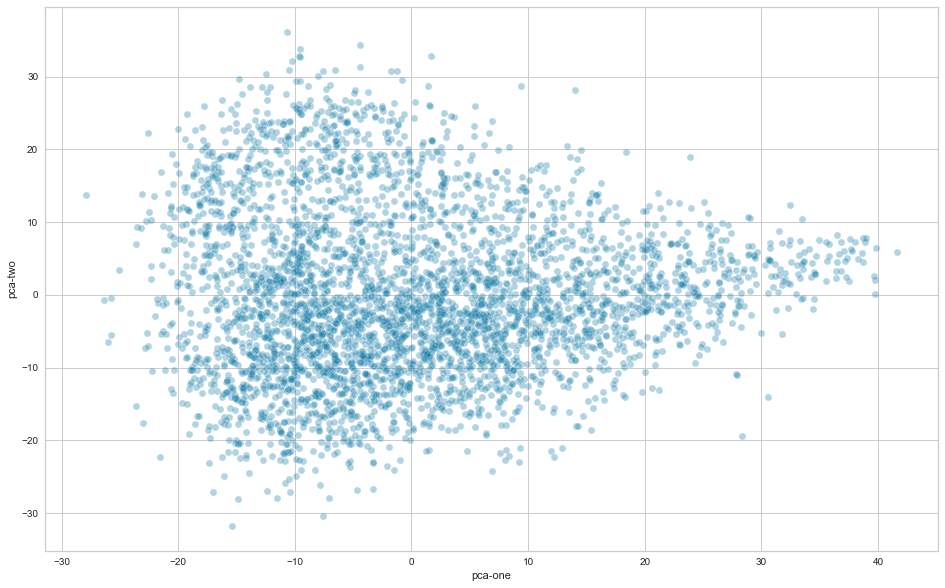

In [30]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    palette=sns.color_palette("hls", 10),
    data=df.loc[rndperm, :],
    legend="full",
    alpha=0.3
)

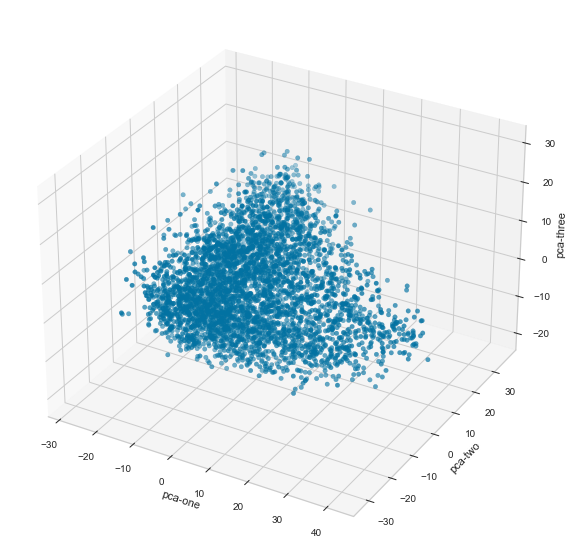

In [31]:
ax = plt.figure(figsize=(16,10)).add_subplot(projection='3d')
ax.scatter(
    xs=df.loc[rndperm,:]["pca-one"], 
    ys=df.loc[rndperm,:]["pca-two"], 
    zs=df.loc[rndperm,:]["pca-three"]     
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

## Visualization after t-SNE

In [158]:
# reduce the amount of dimensions in the feature vector
pca = PCA(n_components=10, random_state=22)
pca.fit(feat)
x = pca.transform(feat)

In [159]:
N = 3926

df_subset = df.loc[rndperm[:N],:].copy()

data_subset = df_subset[feat_cols].values

pca = PCA(n_components=3)
pca_result = pca.fit_transform(data_subset)

df_subset['pca-one'] = pca_result[:,0]
df_subset['pca-two'] = pca_result[:,1] 
df_subset['pca-three'] = pca_result[:,2]

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.4248007  0.32840818 0.24679111]


In [160]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=200, n_iter=100000)
tsne_results = tsne.fit_transform(data_subset)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

C:\Users\Dennis\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Dennis\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 601 nearest neighbors...
[t-SNE] Indexed 3926 samples in 0.000s...
[t-SNE] Computed neighbors for 3926 samples in 1.247s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3926
[t-SNE] Computed conditional probabilities for sample 2000 / 3926
[t-SNE] Computed conditional probabilities for sample 3000 / 3926
[t-SNE] Computed conditional probabilities for sample 3926 / 3926
[t-SNE] Mean sigma: 5.194319
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.496803
[t-SNE] KL divergence after 3000 iterations: 0.765638
t-SNE done! Time elapsed: 7565.306953907013 seconds


C:\Users\Dennis\AppData\Local\Temp\ipykernel_42396\3443332944.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

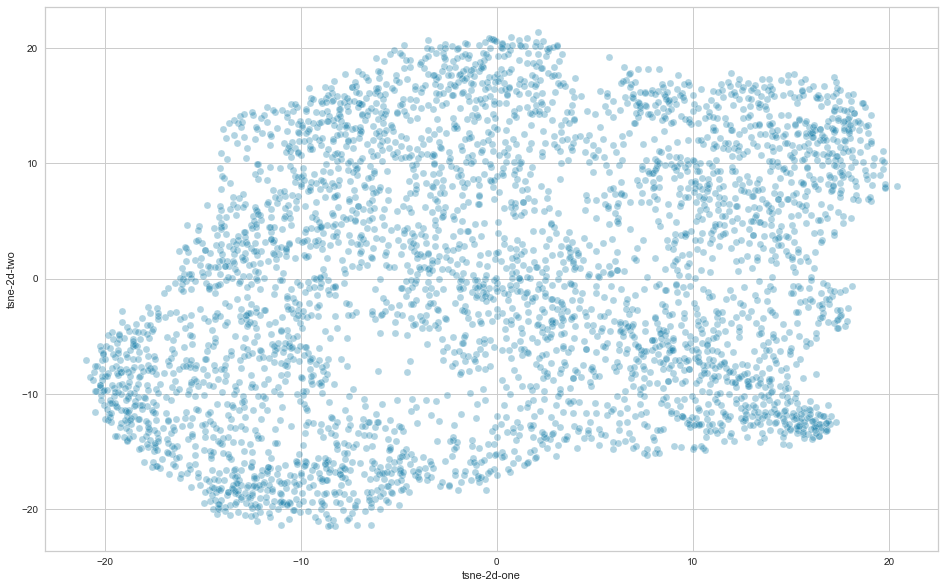

In [161]:
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    ## hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3
)

C:\Users\Dennis\AppData\Local\Temp\ipykernel_42396\2554496077.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(
C:\Users\Dennis\AppData\Local\Temp\ipykernel_42396\2554496077.py:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

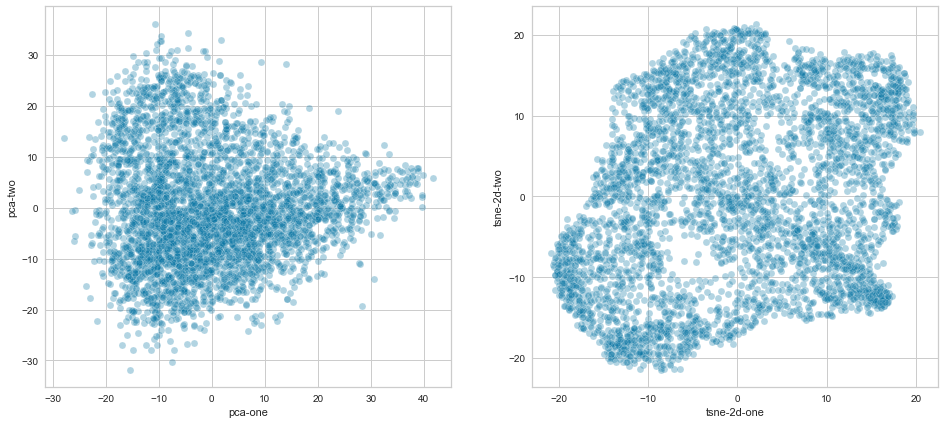

In [162]:
plt.figure(figsize=(16,7))

ax1 = plt.subplot(1, 2, 1)
sns.scatterplot(
    x="pca-one", y="pca-two",
    ## hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax1
)

ax2 = plt.subplot(1, 2, 2)
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    ## hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax2
)

In [163]:
# reduce the amount of dimensions in the feature vector
pca = PCA(n_components=100, random_state=22)
pca.fit(feat)
x = pca.transform(feat)

In [164]:
pca_50 = PCA(n_components=3)
pca_result_50 = pca_50.fit_transform(data_subset)

print('Cumulative explained variation for 50 principal components: {}'.format(np.sum(pca_50.explained_variance_ratio_)))

Cumulative explained variation for 50 principal components: 1.0


In [165]:
time_start = time.time()

tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_pca_results = tsne.fit_transform(pca_result_50)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

C:\Users\Dennis\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Dennis\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


t-SNE done! Time elapsed: 9.819028854370117 seconds


C:\Users\Dennis\AppData\Local\Temp\ipykernel_42396\3786106993.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(
C:\Users\Dennis\AppData\Local\Temp\ipykernel_42396\3786106993.py:16: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(
C:\Users\Dennis\AppData\Local\Temp\ipykernel_42396\3786106993.py:27: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


<AxesSubplot:xlabel='tsne-pca50-one', ylabel='tsne-pca50-two'>

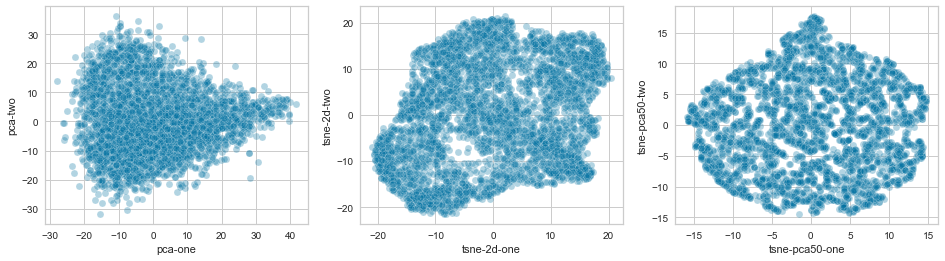

In [166]:
df_subset['tsne-pca50-one'] = tsne_pca_results[:,0]
df_subset['tsne-pca50-two'] = tsne_pca_results[:,1]
plt.figure(figsize=(16,4))
ax1 = plt.subplot(1, 3, 1)
sns.scatterplot(
    x="pca-one", y="pca-two",
    ## hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax1
)

ax2 = plt.subplot(1, 3, 2)
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    ## hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax2
)

ax3 = plt.subplot(1, 3, 3)
sns.scatterplot(
    x="tsne-pca50-one", y="tsne-pca50-two",
    ## hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax3
)

## K-Means

In [32]:
# reduce the amount of dimensions in the feature vector
pca = PCA(n_components=3, random_state=22)
pca.fit(feat)
x = pca.transform(feat)

In [33]:
# this is just incase you want to see which value for k might be the best 
sse = []
list_k = list(range(2, 20))

In [34]:
## x = data_rescaled

In [35]:
pbar1 = ProgressBar()

In [36]:
for k in pbar1(list_k):
    km = KMeans(n_clusters=k, random_state=22)
    km.fit(x)
    
    sse.append(km.inertia_)

100% |########################################################################|


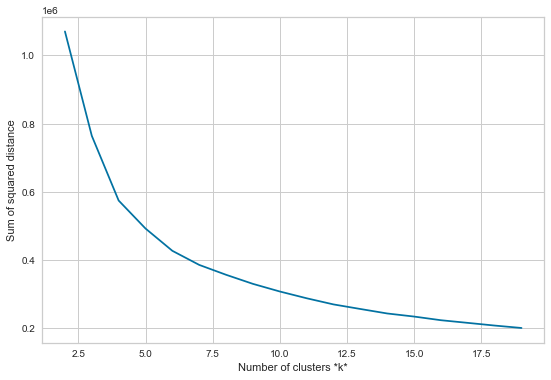

In [125]:
# Plot sse against k
plt.figure(figsize=(9, 6))
plt.plot(list_k, sse)
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

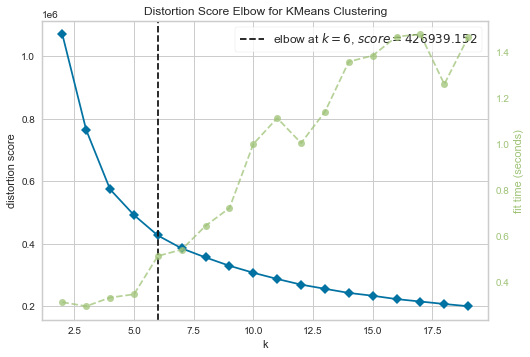

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [38]:
model = KMeans(random_state=22)

elb_visualizer = KElbowVisualizer(model, k=(2,20))
elb_visualizer.fit(x)    
elb_visualizer.show()

In [39]:
# cluster feature vectors
kmeans = KMeans(n_clusters=6, random_state=22)
kmeans.fit(x)

KMeans(n_clusters=6, random_state=22)

In [40]:
score = silhouette_score(x, kmeans.labels_)
print("For n_clusters = {}, silhouette score is {})".format(6, score))

For n_clusters = 6, silhouette score is 0.30320829153060913)


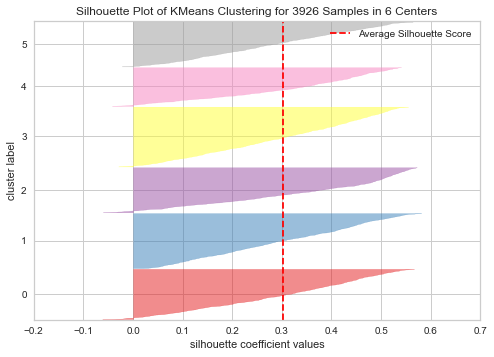

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 3926 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [41]:
sil_visualizer = SilhouetteVisualizer(kmeans)
sil_visualizer.fit(x)    
sil_visualizer.show()

In [42]:
feat_cols_kmeans = [ 'pixel'+str(i) for i in range(x.shape[1]) ]

In [43]:
df_kmeans = pd.DataFrame(x,columns=feat_cols_kmeans)

In [44]:
df_kmeans['y'] = kmeans.labels_

In [45]:
pca_kmeans = PCA(n_components=3)
pca_result_kmeans = pca_kmeans.fit_transform(df_kmeans[feat_cols_kmeans].values)

df_kmeans['pca-one'] = pca_result_kmeans[:,0]
df_kmeans['pca-two'] = pca_result_kmeans[:,1] 
df_kmeans['pca-three'] = pca_result_kmeans[:,2]

In [46]:
print('Explained variation per principal component: {}'.format(pca_kmeans.explained_variance_ratio_))

Explained variation per principal component: [0.4248006  0.3284082  0.24679114]


In [47]:
# For reproducability of the results
np.random.seed(42)

rndperm_kmeans = np.random.permutation(df_kmeans.shape[0])

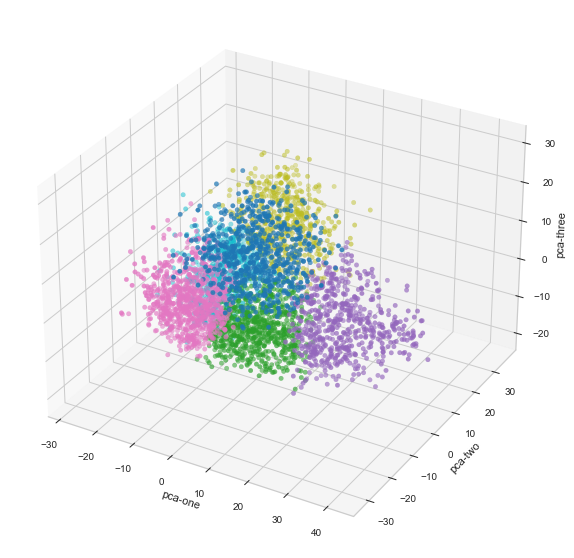

In [48]:
ax = plt.figure(figsize=(16,10)).add_subplot(projection='3d')
ax.scatter(
    xs=df_kmeans.loc[rndperm_kmeans,:]["pca-one"], 
    ys=df_kmeans.loc[rndperm_kmeans,:]["pca-two"], 
    zs=df_kmeans.loc[rndperm_kmeans,:]["pca-three"], 
    c=df_kmeans.loc[rndperm_kmeans,:]["y"], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

In [49]:
# holds the cluster id and the images { id: [images] }
groups = {}
for file, cluster in zip(filenames,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

In [138]:
# Create folders for each cluster in host

for i in range(kmeans.labels_.max()+1):
    # makeadir() evaluates your condition
    out_path = 'C:\\Users\\Dennis\\Documents\\SE512\\Data_Mining_Project\\KMEANS\\{}'.format(i)
    if not os.path.exists(out_path):
        os.mkdir(out_path)

In [139]:
pbar2 = ProgressBar()

In [140]:
# Put all images of each cluster into thier respective folders on host for examination
source_path = r"C:\Users\Dennis\Documents\SE512\Data_Mining_Project\Images_from_S3_3"
# Create array from images in source path
source_list = []
for images in os.scandir(source_path):
        source_list.append(images)
# For loor copies images over into the clustered folders
for i in pbar2(range(len(kmeans.labels_))):
    if kmeans.labels_[i] != -1:
        folder = kmeans.labels_[i]
        out_path = r'C:\\Users\\Dennis\\Documents\\SE512\\Data_Mining_Project\\KMEANS\\{}'.format(folder)
        image_select = source_list[i]
        shutil.copy(image_select, out_path)

100% |########################################################################|


## K-Medoids

In [50]:
# reduce the amount of dimensions in the feature vector
pca = PCA(n_components=3, random_state=22)
pca.fit(feat)
x = pca.transform(feat)

In [51]:
# this is just incase you want to see which value for k might be the best 
sse2 = []
list_kM = list(range(2, 20))

In [52]:
pbar1 = ProgressBar()

In [53]:
for k in pbar1(list_kM):
    kM = KMedoids(n_clusters=k, metric='euclidean', method='alternate', init='heuristic', max_iter=300, random_state=22)
    kM.fit(x)
    
    sse2.append(kM.inertia_)

100% |########################################################################|


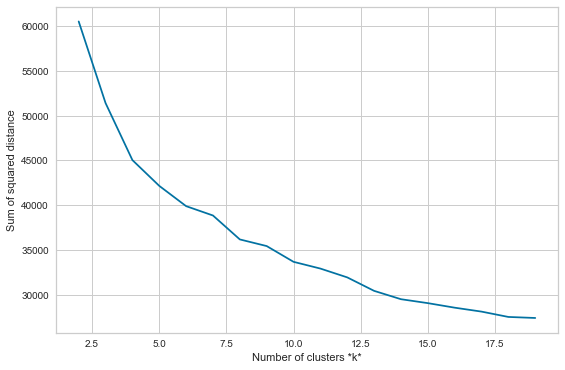

In [126]:
# Plot sse against k
plt.figure(figsize=(9, 6))
plt.plot(list_kM, sse2)
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

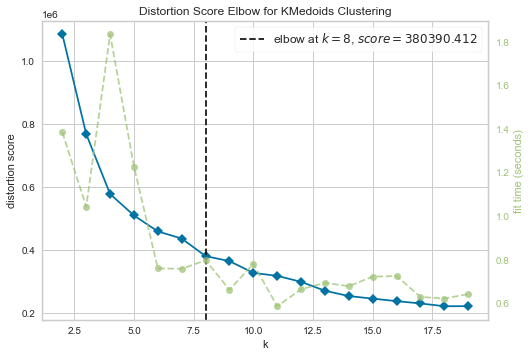

<AxesSubplot:title={'center':'Distortion Score Elbow for KMedoids Clustering'}, xlabel='k', ylabel='distortion score'>

In [55]:
model = KMedoids(random_state=22)

elb_visualizer = KElbowVisualizer(model, k=(2,20))
elb_visualizer.fit(x)    
elb_visualizer.show()

In [56]:
Kmedoids_Cluster_Size = 4

In [57]:
# cluster feature vectors
kmedoids = KMedoids(n_clusters=Kmedoids_Cluster_Size, metric='euclidean', method='alternate', init='heuristic', max_iter=300, random_state=22)
kmedoids.fit(x)

KMedoids(n_clusters=4, random_state=22)

In [58]:
kmedoids.labels_

array([2, 2, 1, ..., 2, 3, 3], dtype=int64)

In [59]:
score = silhouette_score(x, kmedoids.labels_)
print("For n_clusters = {}, silhouette score is {})".format(5, score))

For n_clusters = 5, silhouette score is 0.326805979013443)


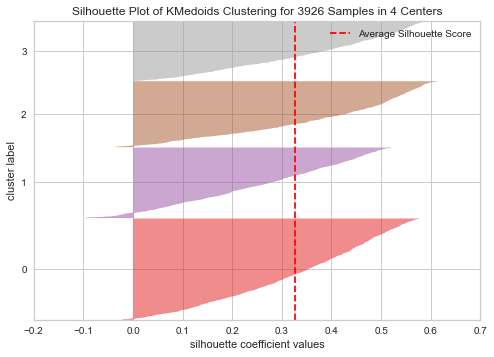

<AxesSubplot:title={'center':'Silhouette Plot of KMedoids Clustering for 3926 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [60]:
sil_visualizer = SilhouetteVisualizer(kmedoids)
sil_visualizer.fit(x)    
sil_visualizer.show()

In [61]:
feat_cols_kmedoids = [ 'pixel'+str(i) for i in range(x.shape[1]) ]

In [62]:
df_kmedoids = pd.DataFrame(x,columns=feat_cols_kmedoids)

In [63]:
df_kmedoids['y'] = kmedoids.labels_

In [64]:
pca_kmedoids = PCA(n_components=3)
pca_result_kmedoids = pca_kmedoids.fit_transform(df_kmedoids[feat_cols_kmedoids].values)

df_kmedoids['pca-one'] = pca_result_kmedoids[:,0]
df_kmedoids['pca-two'] = pca_result_kmedoids[:,1] 
df_kmedoids['pca-three'] = pca_result_kmedoids[:,2]

In [65]:
print('Explained variation per principal component: {}'.format(pca_kmedoids.explained_variance_ratio_))

Explained variation per principal component: [0.4248006  0.3284082  0.24679114]


In [66]:
# For reproducability of the results
np.random.seed(42)

rndperm_kmedoids = np.random.permutation(df_kmedoids.shape[0])

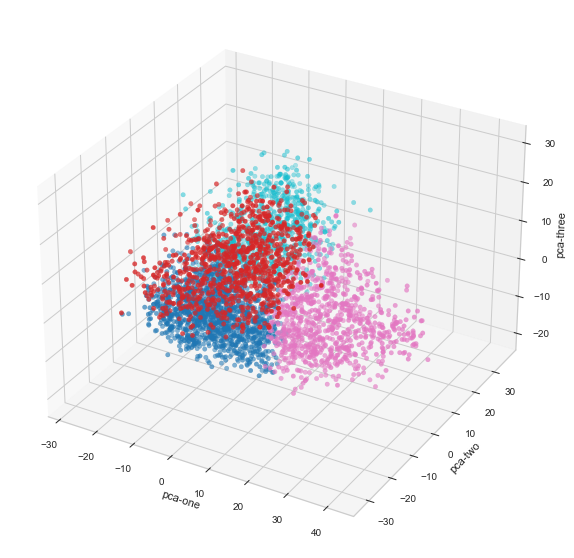

In [67]:
ax = plt.figure(figsize=(16,10)).add_subplot(projection='3d')
ax.scatter(
    xs=df_kmedoids.loc[rndperm_kmedoids,:]["pca-one"], 
    ys=df_kmedoids.loc[rndperm_kmedoids,:]["pca-two"], 
    zs=df_kmedoids.loc[rndperm_kmedoids,:]["pca-three"], 
    c=df_kmedoids.loc[rndperm_kmedoids,:]["y"], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

In [68]:
# holds the cluster id and the images { id: [images] }
groups = {}
for file, cluster in zip(filenames,kmedoids.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

In [142]:
# Create folders for each cluster in host

for i in range(kmedoids.labels_.max()+1):
    # makeadir() evaluates your condition
    out_path = 'C:\\Users\\Dennis\\Documents\\SE512\\Data_Mining_Project\\KMEDOIDS\\{}'.format(i)
    if not os.path.exists(out_path):
        os.mkdir(out_path)

In [143]:
pbar2 = ProgressBar()

In [144]:
# Put all images of each cluster into thier respective folders on host for examination
source_path = r"C:\Users\Dennis\Documents\SE512\Data_Mining_Project\Images_from_S3_3"
# Create array from images in source path
source_list = []
for images in os.scandir(source_path):
        source_list.append(images)
# For loor copies images over into the clustered folders
for i in pbar2(range(len(kmedoids.labels_))):
    folder = kmedoids.labels_[i]
    out_path = r'C:\\Users\\Dennis\\Documents\\SE512\\Data_Mining_Project\\KMEDOIDS\\{}'.format(folder)
    image_select = source_list[i]
    shutil.copy(image_select, out_path)

100% |########################################################################|


## DBSCAN

In [69]:
# reduce the amount of dimensions in the feature vector
pca = PCA(n_components=3, random_state=22)
pca.fit(feat)
x_db = pca.transform(feat)

[0.06900832 0.06900832 0.17866267 ... 6.95216705 9.68209091 9.68209091]


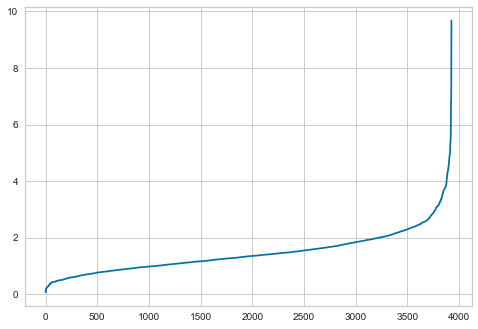

In [70]:
nearest_neighbors = NearestNeighbors(n_neighbors=5)
nearest_neighbors.fit(x_db)
distances, indices = nearest_neighbors.kneighbors(x_db)
distances = np.sort(distances, axis=0)[:, 1]
print(distances)
plt.plot(distances)
plt.show()

In [71]:
db = DBSCAN(eps=3, min_samples=20).fit(x_db)

In [72]:
# Creating a numpy array with all values set to false by default
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)

In [73]:
# Setting core and border points (all points that are not -1) to True
core_samples_mask[db.core_sample_indices_] = True

In [74]:
# Finding the number of clusters in labels (ignoring noise if present)
n_clusters_ = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
n_noise_ = list(db.labels_).count(-1)

In [75]:
# Printing the number of clusters and number of noise points (outliers)
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 4
Estimated number of noise points: 2976


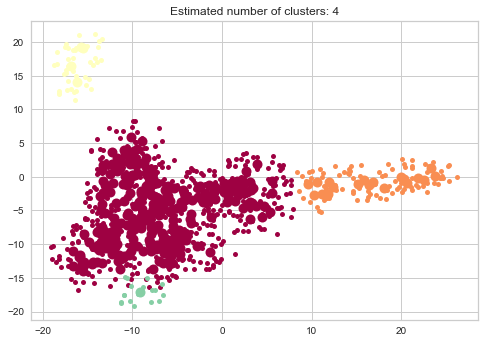

In [76]:
unique_labels = set(db.labels_)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
for k, col in zip(unique_labels, colors):
    if k != -1:
        # Black used for noise
        # col = "k"
    
        class_member_mask = (db.labels_ == k)
        xy = x_db[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], "o", markerfacecolor=col,
        markeredgecolor="k", markersize=10)
        xy = x_db[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], "o", markerfacecolor=col,
        markeredgecolor="k", markersize=5)
plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

In [77]:
feat_cols_db = [ 'pixel'+str(i) for i in range(x.shape[1]) ]

In [78]:
df_db = pd.DataFrame(x,columns=feat_cols_db)

In [79]:
print('Size of the dataframe: {}'.format(df_db.shape))

Size of the dataframe: (3926, 3)


In [80]:
df_db['y'] = db.labels_

In [81]:
pca_db = PCA(n_components=3)
pca_result_db = pca_db.fit_transform(df[feat_cols_db].values)

df_db['pca-one'] = pca_result_db[:,0]
df_db['pca-two'] = pca_result_db[:,1] 
df_db['pca-three'] = pca_result_db[:,2]

In [82]:
# For reproducability of the results
np.random.seed(42)

rndperm_db = np.random.permutation(df_db.shape[0])

<AxesSubplot:xlabel='pca-one', ylabel='pca-two'>

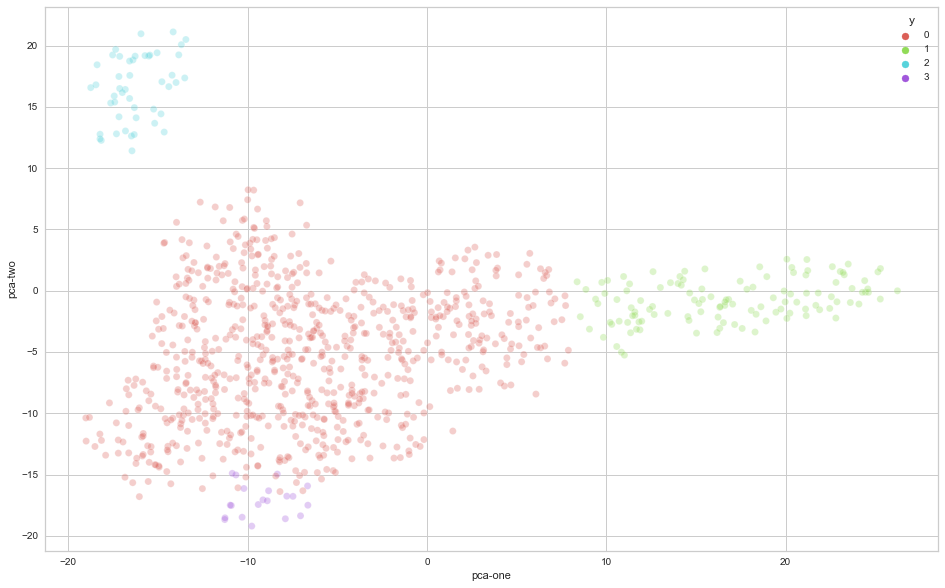

In [83]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", db.labels_.max()+1),
    data=df_db.loc[df_db['y'] != -1,:],
    legend="full",
    alpha=0.3
)

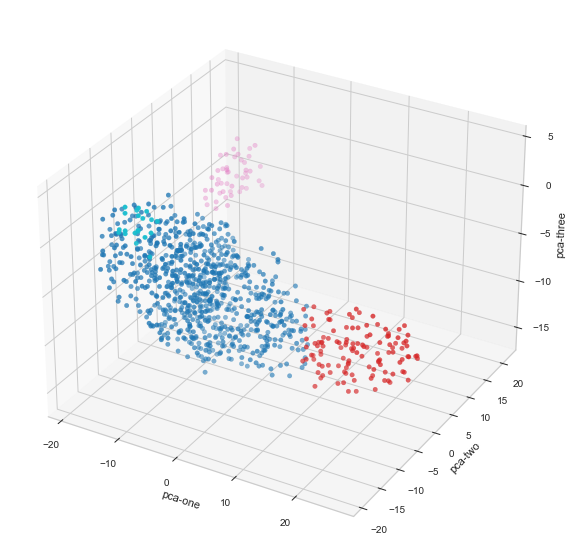

In [84]:
ax = plt.figure(figsize=(16,10)).add_subplot(projection='3d')
ax.scatter(
    xs=df_db.loc[df_db['y'] != -1,:]["pca-one"], 
    ys=df_db.loc[df_db['y'] != -1,:]["pca-two"], 
    zs=df_db.loc[df_db['y'] != -1,:]["pca-three"], 
    c=df_db.loc[df_db['y'] != -1,:]["y"], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

In [85]:
# holds the cluster id and the images { id: [images] }
groups = {}
for file, cluster in zip(filenames,db.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

In [146]:
# Create folders for each cluster in host

for i in range(db.labels_.max()+1):
    # makeadir() evaluates your condition
    out_path = 'C:\\Users\\Dennis\\Documents\\SE512\\Data_Mining_Project\\DBSCAN\{}'.format(i)
    if not os.path.exists(out_path):
        os.mkdir(out_path)

In [147]:
pbar2 = ProgressBar()

In [148]:
# Put all images of each cluster into thier respective folders on host for examination
source_path = r"C:\Users\Dennis\Documents\SE512\Data_Mining_Project\Images_from_S3_3"
# Create array from images in source path
source_list = []
for images in os.scandir(source_path):
        source_list.append(images)
# For loor copies images over into the clustered folders
for i in pbar2(range(len(db.labels_))):
    if db.labels_[i] != -1:
        folder = db.labels_[i]
        out_path = r'C:\\Users\\Dennis\\Documents\\SE512\\Data_Mining_Project\\DBSCAN\{}'.format(folder)
        image_select = source_list[i]
        shutil.copy(image_select, out_path)

100% |########################################################################|


## HDBSCAN

In [86]:
# reduce the amount of dimensions in the feature vector
pca = PCA(n_components=3, random_state=22)
pca.fit(feat)
x = pca.transform(feat)

In [87]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=15, metric='euclidean',cluster_selection_method='leaf',gen_min_span_tree=True)
cluster_labels = clusterer.fit_predict(x)

In [88]:
print(f"DBCV score {clusterer.relative_validity_}")

DBCV score 0.08472269786513402


In [89]:
unique_labels = set(clusterer.labels_)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

In [90]:
print(unique_labels)

{0, 1, 2, 3, 4, 5, 6, 7, 8, -1}


In [91]:
print(cluster_labels)

[-1  1 -1 ... -1 -1 -1]


In [92]:
# Finding the number of clusters in labels (ignoring noise if present)
num_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
num_noise = list(cluster_labels).count(-1)

In [93]:
# Printing the number of clusters and number of noise points (outliers)
print("Estimated number of clusters: %d" % num_clusters)
print("Estimated number of noise points: %d" % num_noise) 

Estimated number of clusters: 9
Estimated number of noise points: 3472


In [94]:
print(x[0])

[18.05012    9.82531   -1.6740565]


In [95]:
print(cluster_labels.shape)

(3926,)


In [96]:
feat_cols = [ 'pixel'+str(i) for i in range(x.shape[1]) ]

In [97]:
df = pd.DataFrame(x,columns=feat_cols)

In [98]:
print('Size of the dataframe: {}'.format(df.shape))

Size of the dataframe: (3926, 3)


In [99]:
df['y'] = cluster_labels

In [100]:
print(df)

         pixel0     pixel1     pixel2  y
0     18.050119   9.825310  -1.674057 -1
1     20.795223   6.134795  -1.666922  1
2      3.490858  -3.519226  24.917511 -1
3    -18.779390   8.465159  -4.320531 -1
4     -9.111283  22.781292   9.473613  0
...         ...        ...        ... ..
3921  14.291797  11.265872  -5.830252 -1
3922  15.969303  12.883803  -3.942819 -1
3923  12.513424  14.768106  -6.020113 -1
3924  -9.663297  32.794868   9.153008 -1
3925  -7.977204  30.035578   9.616458 -1

[3926 rows x 4 columns]


In [101]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df[feat_cols].values)

df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]

In [102]:
print(df)

         pixel0     pixel1     pixel2  y    pca-one    pca-two  pca-three
0     18.050119   9.825310  -1.674057 -1  18.050158   9.825290  -1.674059
1     20.795223   6.134795  -1.666922  1  20.795223   6.134782  -1.666933
2      3.490858  -3.519226  24.917511 -1   3.490856  -3.519206  24.917501
3    -18.779390   8.465159  -4.320531 -1 -18.779392   8.465157  -4.320539
4     -9.111283  22.781292   9.473613  0  -9.111286  22.781301   9.473591
...         ...        ...        ... ..        ...        ...        ...
3921  14.291797  11.265872  -5.830252 -1  14.291797  11.265867  -5.830262
3922  15.969303  12.883803  -3.942819 -1  15.969302  12.883801  -3.942831
3923  12.513424  14.768106  -6.020113 -1  12.513422  14.768103  -6.020125
3924  -9.663297  32.794868   9.153008 -1  -9.663300  32.794876   9.152979
3925  -7.977204  30.035578   9.616458 -1  -7.977207  30.035587   9.616431

[3926 rows x 7 columns]


In [103]:
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.4248006  0.3284082  0.24679114]


In [104]:
# For reproducability of the results
np.random.seed(42)

rndperm = np.random.permutation(df.shape[0])

In [105]:
print(df.loc[rndperm,:])

         pixel0     pixel1     pixel2  y    pca-one    pca-two  pca-three
3476  12.155616   8.503244  13.316059 -1  12.155615   8.503255  13.316049
463  -10.486803  23.760189  -2.962332 -1 -10.486806  23.760187  -2.962353
3857   0.615743 -10.660816  14.862968 -1   0.615741 -10.660804  14.862974
3173 -12.844351  -8.088078   1.087112 -1 -12.844353  -8.088078   1.087116
2092  -5.511511  23.946976  15.682080 -1  -5.511514  23.946989  15.682056
...         ...        ...        ... ..        ...        ...        ...
1130 -11.554061 -12.480507  -5.420523  6 -11.554064 -12.480513  -5.420515
1294  -4.822026  -8.972872 -14.699047 -1  -4.822029  -8.972884 -14.699040
860    9.301748 -21.007811   3.468542 -1   9.301747 -21.007809   3.468557
3507 -13.737591 -13.975690  -1.029395 -1 -13.737594 -13.975692  -1.029386
3174  -7.694067 -16.607794  19.393742 -1  -7.694070 -16.607777  19.393753

[3926 rows x 7 columns]


<AxesSubplot:xlabel='pca-one', ylabel='pca-two'>

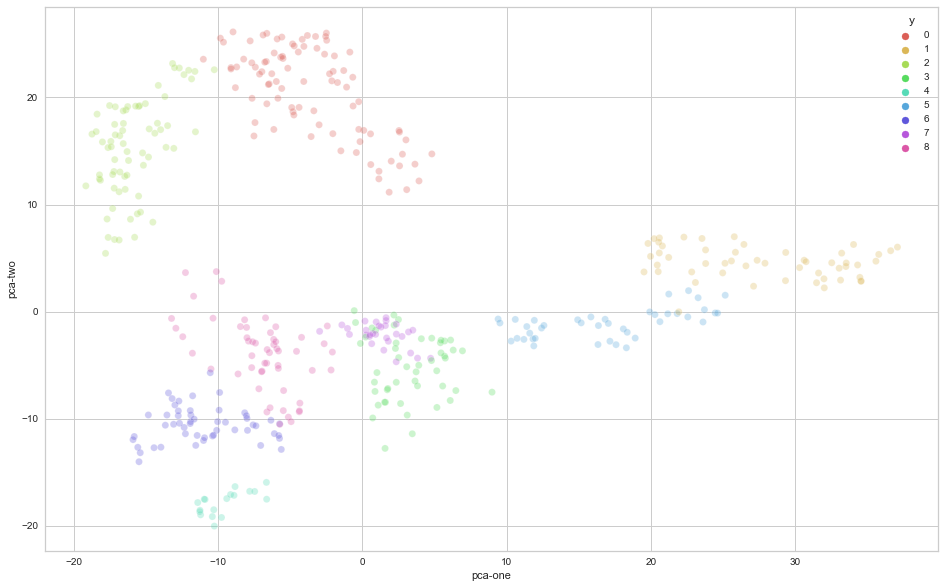

In [106]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", clusterer.labels_.max()+1),
    data=df.loc[df['y'] != -1,:],
    legend="full",
    alpha=0.3
)

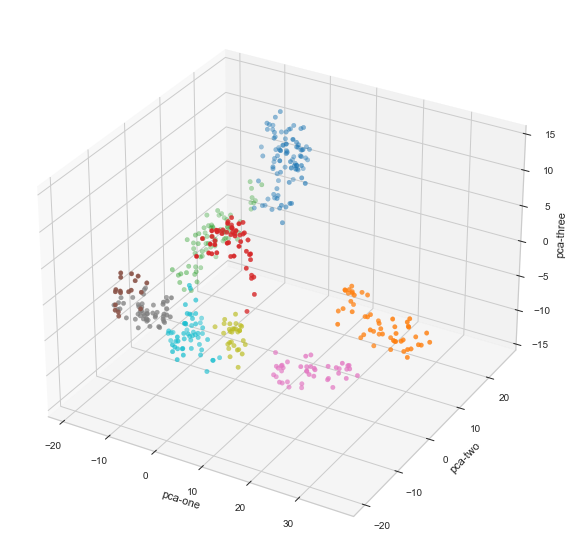

In [107]:
ax = plt.figure(figsize=(16,10)).add_subplot(projection='3d')
ax.scatter(
    xs=df.loc[df['y'] != -1,:]["pca-one"], 
    ys=df.loc[df['y'] != -1,:]["pca-two"], 
    zs=df.loc[df['y'] != -1,:]["pca-three"], 
    c=df.loc[df['y'] != -1,:]["y"], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

In [108]:
clusterer.labels_.max()

8

In [109]:
clusterer.probabilities_

array([0.        , 0.93655844, 0.        , ..., 0.        , 0.        ,
       0.        ])

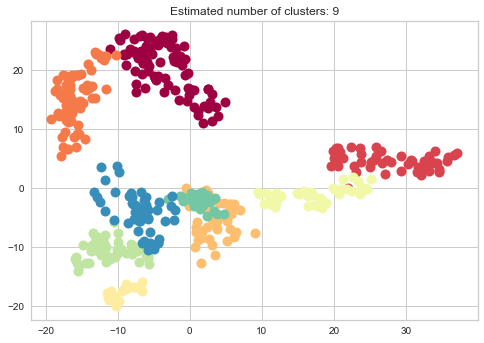

In [110]:
unique_labels = set(clusterer.labels_)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
for k, col in zip(unique_labels, colors):
    if k != -1:
        # Black used for noise  
        class_member_mask = (clusterer.labels_ == k)
        xy = x[class_member_mask]
        plt.plot(xy[:, 0], xy[:, 1], "o", markerfacecolor=col,
        markeredgecolor="k", markersize=10)
        xy = x[class_member_mask]
        plt.plot(xy[:, 0], xy[:, 1], "o", markerfacecolor=col,
        markeredgecolor="k", markersize=5)
plt.title("Estimated number of clusters: %d" % (clusterer.labels_.max() + 1))
plt.show()

C:\Users\Dennis\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Dennis\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<AxesSubplot:>

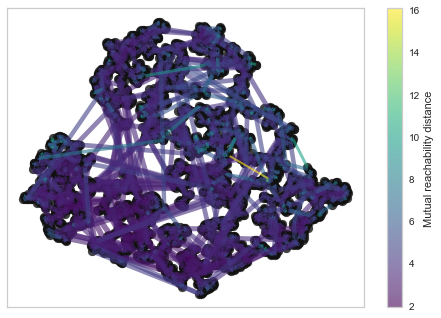

In [264]:
clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis',
                                      edge_alpha=0.6,
                                      node_size=80,
                                      edge_linewidth=2)

In [ ]:
clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=True)

<AxesSubplot:ylabel='$\\lambda$ value'>

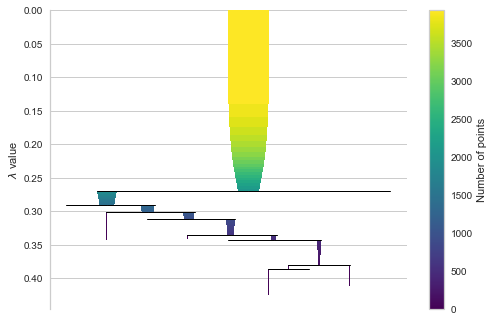

In [265]:
clusterer.condensed_tree_.plot()

<AxesSubplot:ylabel='$\\lambda$ value'>

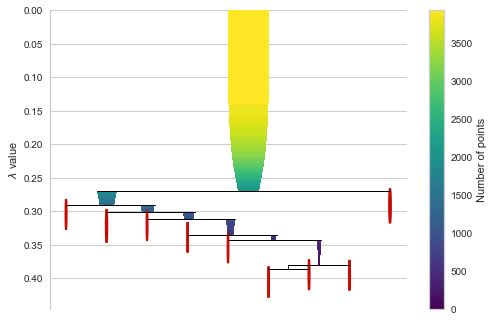

In [266]:
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())

In [112]:
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}

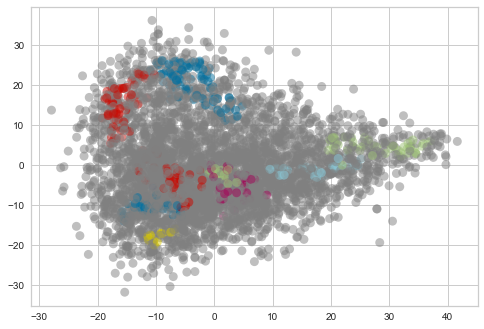

In [113]:
palette = sns.color_palette(n_colors = 30)
cluster_colors = [sns.desaturate(palette[col], sat)
                  if col >= 0 else (0.5, 0.5, 0.5) for col, sat in
                  zip(clusterer.labels_, clusterer.probabilities_)]
plt.scatter(x.T[0], x.T[1], c=cluster_colors, **plot_kwds)

In [408]:
# holds the cluster id and the images { id: [images] }
groups = {}
for file, cluster in zip(filenames,clusterer.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

In [409]:
# Create folders for each cluster in host

for i in range(clusterer.labels_.max()+1):
    # makeadir() evaluates your condition
    out_path = 'C:\\Users\\Dennis\\Documents\\SE512\\Data_Mining_Project\\HDBSCAN\\{}'.format(i)
    if not os.path.exists(out_path):
        os.mkdir(out_path)

In [410]:
pbar2 = ProgressBar()

In [411]:
# Put all images of each cluster into thier respective folders on host for examination
source_path = r"C:\Users\Dennis\Documents\SE512\Data_Mining_Project\Images_from_S3_3"
# Create array from images in source path
source_list = []
for images in os.scandir(source_path):
        source_list.append(images)
# For loor copies images over into the clustered folders
for i in pbar2(range(len(clusterer.labels_))):
    if clusterer.labels_[i] != -1:
        folder = clusterer.labels_[i]
        out_path = r'C:\\Users\\Dennis\\Documents\\SE512\\Data_Mining_Project\\HDBSCAN\\{}'.format(folder)
        image_select = source_list[i]
        shutil.copy(image_select, out_path)

100% |########################################################################|


## Agglomerative Hierarchical clustering

In [114]:
# reduce the amount of dimensions in the feature vector
pca = PCA(n_components=3, random_state=22)
pca.fit(feat)
x = pca.transform(feat)

In [133]:
AHC = AgglomerativeClustering(n_clusters = 4).fit(x)

In [134]:
score = silhouette_score(x, AHC.labels_)
print("For n_clusters = {}, silhouette score is {})".format(4, score))

For n_clusters = 4, silhouette score is 0.29404959082603455)


In [117]:
feat_cols_AHC = [ 'pixel'+str(i) for i in range(x.shape[1]) ]

In [118]:
df_AHC = pd.DataFrame(x,columns=feat_cols_AHC)

In [119]:
df_AHC['y'] = AHC.labels_

In [120]:
pca_AHC = PCA(n_components=3)
pca_result_AHC = pca_AHC.fit_transform(df_AHC[feat_cols_AHC].values)

df_AHC['pca-one'] = pca_result_AHC[:,0]
df_AHC['pca-two'] = pca_result_AHC[:,1] 
df_AHC['pca-three'] = pca_result_AHC[:,2]

In [121]:
print('Explained variation per principal component: {}'.format(pca_AHC.explained_variance_ratio_))

Explained variation per principal component: [0.4248006  0.3284082  0.24679114]


In [122]:
# For reproducability of the results
np.random.seed(42)

rndperm_AHC = np.random.permutation(df_AHC.shape[0])

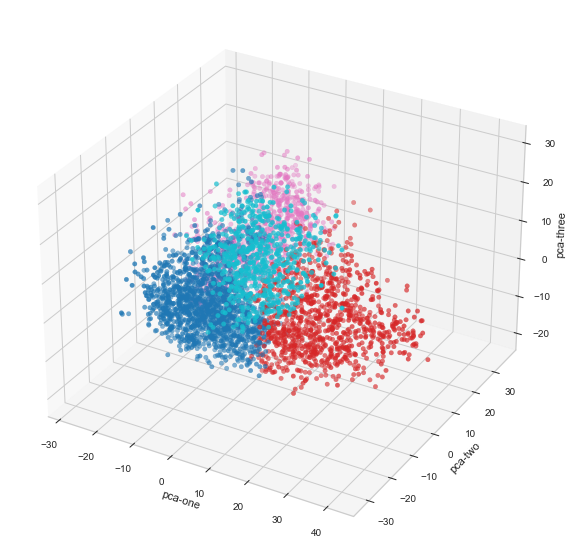

In [123]:
ax = plt.figure(figsize=(16,10)).add_subplot(projection='3d')
ax.scatter(
    xs=df_AHC.loc[rndperm_AHC,:]["pca-one"], 
    ys=df_AHC.loc[rndperm_AHC,:]["pca-two"], 
    zs=df_AHC.loc[rndperm_AHC,:]["pca-three"], 
    c=df_AHC.loc[rndperm_AHC,:]["y"], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

In [163]:
# holds the cluster id and the images { id: [images] }
groups = {}
for file, cluster in zip(filenames,AHC.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

In [164]:
# Create folders for each cluster in host

for i in range(AHC.labels_.max()+1):
    # makeadir() evaluates your condition
    out_path = 'C:\\Users\\Dennis\\Documents\\SE512\\Data_Mining_Project\\AHC\\{}'.format(i)
    if not os.path.exists(out_path):
        os.mkdir(out_path)

In [165]:
pbar2 = ProgressBar()

In [166]:
# Put all images of each cluster into thier respective folders on host for examination
source_path = r"C:\Users\Dennis\Documents\SE512\Data_Mining_Project\Images_from_S3_3"
# Create array from images in source path
source_list = []
for images in os.scandir(source_path):
        source_list.append(images)
# For loor copies images over into the clustered folders
for i in pbar2(range(len(AHC.labels_))):
    folder = AHC.labels_[i]
    out_path = r'C:\\Users\\Dennis\\Documents\\SE512\\Data_Mining_Project\\AHC\\{}'.format(folder)
    image_select = source_list[i]
    shutil.copy(image_select, out_path)

100% |########################################################################|
